### Scaling and role assignment visualisation
In this notebook, we visualize player avrg position (before and after scaling states) by drawing their average position using matplotlip. And also show example of how we assign their roles. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import matplotlib
from IPython import display
from itertools import count
import matplotlib.lines as mlines
import os

Scaling down positions to the range of min and max based on their standard deviations

In [2]:
def scale_linear_data(rawpoints, high, low, std):
    mins = np.min(rawpoints, axis=0)
    maxs = np.max(rawpoints, axis=0)
    rng = maxs - mins
    high = high - std
    low = low + std
    return high - (((high - low) * (maxs - rawpoints)) / rng)

Role defining 

In [3]:
def define_role(x, y, pitch_value, gk_state):
    
    # gk_state==1 := golakeeper
    if gk_state==1:
        return 10
    else:
        for pitch_i in range(0,10):
            if x>=pitch_value[pitch_i][0] and x<=pitch_value[pitch_i][1] and y>=pitch_value[pitch_i][2] and y<=pitch_value[pitch_i][3]:
                return pitch_i
    return -1

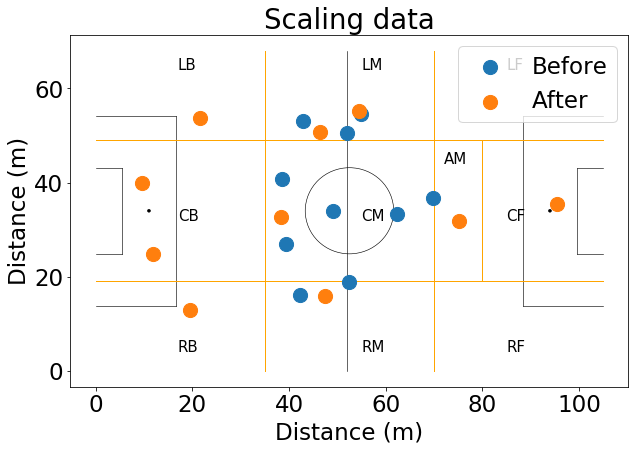

Players' role assignation

[ 11.85219552  24.88572765] -> Left Back
[  9.61546172  39.9642036 ] -> Left Back
[ 54.51582183  55.16383605] -> Right Midfielder
[ 47.52948043  15.90913312] -> Left Midfielder
[ 46.42492053  50.6810459 ] -> Right Midfielder
[ 38.36163322  32.65075726] -> Center Midfielder
[ 95.38453828  35.51445613] -> Center Forward
[ 21.57232268  53.67691548] -> Right Back
[ 19.52888686  12.83616395] -> Left Back
[ 75.17109204  31.82469028] -> Atacking Midfielder


In [16]:
match_id = 60656

try:
    avrg_pos = np.load('../data/match_{}/averga_pose_smp.npy'.format(math_id))
except FileNotFoundError:
    avrg_pos = None



font = {'size'   : 23}

matplotlib.rc('font', **font)

width, height = 105, 68
plt.figure(figsize=(10, 10*height/width))

plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')

size = 200
ax = plt.gca()
mid_circ = plt.Circle((52.5, 34), 9.15, color='black', fill=False, linewidth=0.6, zorder=1)
left_pen_circ = plt.Circle((11, 34), 0.3, color='black', fill=True, linewidth=0.6, zorder=1)
right_pen_circ = plt.Circle((94, 34), 0.3, color='black', fill=True, linewidth=0.6, zorder=1)
# middle line
ax.add_line(mlines.Line2D((52, 52), (0, 68), color='black', linewidth=0.6, zorder=1))

# circles
ax.add_artist(mid_circ)
ax.add_artist(left_pen_circ)
ax.add_artist(right_pen_circ)

# left part
ax.add_line(mlines.Line2D((0, 16.5), (13.84, 13.84), color='black', linewidth=0.6, zorder=1))
ax.add_line(mlines.Line2D((0, 16.5), (54.16, 54.16), color='black', linewidth=0.6, zorder=1))
ax.add_line(mlines.Line2D((16.5, 16.5), (13.84, 54.16), color='black', linewidth=0.6, zorder=1))

ax.add_line(mlines.Line2D((0, 5.5), (24.84, 24.84), color='black', linewidth=0.6, zorder=1))
ax.add_line(mlines.Line2D((0, 5.5), (43.16, 43.16), color='black', linewidth=0.6, zorder=1))
ax.add_line(mlines.Line2D((5.5, 5.5), (24.84, 43.16), color='black', linewidth=0.6, zorder=1))

# right part
ax.add_line(mlines.Line2D((88.5, 105), (13.84, 13.84), color='black', linewidth=0.6, zorder=1))
ax.add_line(mlines.Line2D((88.5, 105), (54.16, 54.16), color='black', linewidth=0.6, zorder=1))
ax.add_line(mlines.Line2D((88.5, 88.5), (13.84, 54.16), color='black', linewidth=0.6, zorder=1))

ax.add_line(mlines.Line2D((99.5, 105), (24.84, 24.84), color='black', linewidth=0.6, zorder=1))
ax.add_line(mlines.Line2D((99.5, 105), (43.16, 43.16), color='black', linewidth=0.6, zorder=1))
ax.add_line(mlines.Line2D((99.5, 99.5), (24.84, 43.16), color='black', linewidth=0.6, zorder=1))



# role division
ax.add_line(mlines.Line2D((35, 35), (0, 68), color='orange', linewidth=1, zorder=1))
ax.add_line(mlines.Line2D((0, 105), (19, 19), color='orange', linewidth=1, zorder=1))
ax.add_line(mlines.Line2D((0, 105), (49, 49), color='orange', linewidth=1, zorder=1))
ax.add_line(mlines.Line2D((70, 70), (0, 68), color='orange', linewidth=1, zorder=1))
ax.add_line(mlines.Line2D((80, 80), (19, 49), color='orange', linewidth=1, zorder=1))




ax.text(17, 64, 'LB', fontsize=15)
ax.text(17, 32, 'CB', fontsize=15)
ax.text(17, 4,  'RB', fontsize=15)

ax.text(55, 64, 'LM', fontsize=15)
ax.text(55, 32, 'CM', fontsize=15)
ax.text(72, 44, 'AM', fontsize=15)
ax.text(55, 4,  'RM', fontsize=15)


ax.text(85, 64, 'LF', fontsize=15)
ax.text(85, 32, 'CF', fontsize=15)
ax.text(85, 4,  'RF', fontsize=15)

plt.title('Scaling data')
plt.scatter(avrg_pos[:,0],avrg_pos[:,1], label='Before', s=size, zorder=2)



# find standard deviation of avrg pos data 
stdX = np.std(avrg_pos[:,0])
stdY = np.std(avrg_pos[:,1])

# sclaing 
avrg_pos[:,0] = scale_linear_data(avrg_pos[:,0], 105, 0, stdX)
avrg_pos[:,1] = scale_linear_data(avrg_pos[:,1], 68, 0, stdY)


plt.scatter(avrg_pos[:,0],avrg_pos[:,1], label='After', s=size, zorder=2)
plt.legend(loc=1)
plt.show()


# pitch position index - 0:LB, 1:CB, 2:RB, 3:LM, 4:CM, 5:RM, 6:AM, 7:LF, 8:CF, 9:RF
pitch_positions = [[0, 35, 0, 19],   # Left Back 
                   [0, 35, 19, 49],  # Left Back
                   [0, 35, 49, 68],  # Right Back
                   [35, 70, 0, 19],  # Left Midfielder 
                   [35, 70, 19, 49], # Center Midfielder
                   [35, 70, 49, 68], # Right Midfielder
                   [70, 80, 19, 49], # Atacking Midfielder
                   [70, 105, 0, 19], # Left Forward
                   [80, 105, 19, 49],# Center Forward 
                   [70, 105, 49, 68]]# Right Forward

role_dict = {0:'Left Back',1:'Left Back', 2:'Right Back', 3:'Left Midfielder', 4:'Center Midfielder',
             5:'Right Midfielder', 6:'Atacking Midfielder', 7:'Left Forward', 8:'Center Forward', 9:'Right Forward'}

print("Players' role assignation\n")
for player in avrg_pos:
    role = define_role(player[0],player[1],pitch_positions, 0)
    print(str(player) + " -> " + role_dict[role]) 